# Advance Feature Engineering

### 1. Token Features

* cwc_min: This is the ratio of the number of common words to the length of the smaller question
* cwc_max: This is the ratio of the number of common words to the length of the larger question
* ctc_min: This is the ratio of the number of common tokens to the smaller token count among the two questions
* ctc_max: This is the ratio of the number of common tokens to the larger token count among the two questions
* last_word_eq: 1 if the last word in the two questions is same, 0 otherwise
* first_word_eq: 1 if the first word in the two questions is same, 0 otherwise

### 2. Length Based Features

* mean_len: Mean of the length of the two questions (number of words)
* abs_len_diff: Absolute difference between the length of the two questions (number of words)
* longest_substr_ratio: Ratio of the length of the longest substring among the two questions to the length of the smaller question

### 3. Fuzzy Features

* fuzz_ratio: fuzz_ratio score from fuzzywuzzy
* fuzz_partial_ratio: fuzz_partial_ratio from fuzzywuzzy
* token_sort_ratio: token_sort_ratio from fuzzywuzzy
* token_set_ratio: token_set_ratio from fuzzywuzzy

In [1]:
import pandas as pd
import distance
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from sklearn.svm import SVC
import pickle
import joblib

In [2]:
data=pd.read_csv(r"C:\Users\asus\Documents\Projects\Question_Similarity_Pairs\Input\basic_feature.csv")

In [3]:
# Token Features

def cwc_min(ws,val1,val2):
    c_len=min(val1,val2)
    return ws/c_len

def cwc_max(ws,val1,val2):
    c_len=max(val1,val2)
    return ws/c_len

def ctc_min(q1,q2):
    q1_list=q1.split()
    q2_list=q2.split()
    com_token=len(set(q1_list).intersection(set(q2_list)))
    min_tok=min(len(q1_list),len(q2_list))
    return com_token/min_tok

def ctc_max(q1,q2):
    q1_list=q1.split()
    q2_list=q2.split()
    com_token=len(set(q1_list).intersection(set(q2_list)))
    max_tok=max(len(q1_list),len(q2_list))
    return com_token/max_tok

def last_word_eq(q1,q2):
    q1_last_word=q1.split()[-1]
    q2_last_word=q2.split()[-1]
    if(q1_last_word==q2_last_word):
        return 1
    return 0

def first_word_eq(q1,q2):
    q1_first_word=q1.split()[0]
    q2_first_word=q2.split()[0]
    if(q1_first_word==q2_first_word):
        return 1
    return 0





In [4]:
# Length based features

def longest_substr_ratio(val1,val2):
    m=list(distance.lcsubstrings(val1,val2))
    if(m==[]):
        ls=0
    else:
        ls=len(m[0].split())
    
    return ls/min(len(val1.split()),len(val2.split()))




In [5]:
#Fuzzy based features
from fuzzywuzzy import fuzz
def fuzzy_features(row):
    q1=row['question1']
    q2=row['question2']

    fuzz_feat=[0.0]*4

    #fuzzy ratio
    fuzz_feat[0]=fuzz.QRatio(q1,q2)

    #fuzzy partial ratio
    fuzz_feat[1]=fuzz.partial_ratio(q1,q2)

    #token sort ratio
    fuzz_feat[2]=fuzz.token_set_ratio(q1,q2)

    #token set ratio
    fuzz_feat[3]=fuzz.token_sort_ratio(q1,q2)

    return fuzz_feat




In [6]:
data['cwc_min']=data[['word_share','q1_wordcount','q2_wordcount']].apply(lambda x:cwc_min(*x),axis=1)
data['cwc_max']=data[['word_share','q1_wordcount','q2_wordcount']].apply(lambda x:cwc_max(*x),axis=1)
data['ctc_min']=data[['question1','question2']].apply(lambda x:ctc_min(*x),axis=1)
data['ctc_max']=data[['question1','question2']].apply(lambda x:ctc_max(*x),axis=1)
data['last_word_eq']=data[['question1','question2']].apply(lambda x:last_word_eq(*x),axis=1)
data['first_word_eq']=data[['question1','question2']].apply(lambda x:first_word_eq(*x),axis=1)
#using Length based features
data['mean_len']=data[['q1_wordcount','q2_wordcount']].apply(lambda x:(x[0]+x[1])/2,axis=1)
data['abs_len_diff']=data[['q1_wordcount','q2_wordcount']].apply(lambda x:abs(x[0]-x[1]),axis=1)
data['longest_substr_ratio']=data[['question1','question2']].apply(lambda x:longest_substr_ratio(*x),axis=1)
#using Fuzzy based features
val=data.apply(fuzzy_features,axis=1)
data['fuzzy_ratio']=list(map(lambda x:x[0],val))
data['fuzzy_partial_ratio']=list(map(lambda x:x[1],val))
data['token_set_ratio']=list(map(lambda x:x[2],val))
data['token_sort_ratio']=list(map(lambda x:x[3],val))


In [7]:
data.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,len_ques1,len_ques2,q1_wordcount,q2_wordcount,...,ctc_max,last_word_eq,first_word_eq,mean_len,abs_len_diff,longest_substr_ratio,fuzzy_ratio,fuzzy_partial_ratio,token_set_ratio,token_sort_ratio
0,217099,323388,323389,store fingerprint browser,store browser fingerprint,0,25,25,3,3,...,1.0,0,1,3.0,0,0.333333,68,68,100,100
1,296706,268935,73790,peopl like dog,peopl like dog,1,14,14,3,3,...,1.0,1,1,3.0,0,1.000000,100,100,100,100


In [8]:
data.shape

(59984, 24)

* Let's just do some EDA to find more about the data after the addition of advanced featurization

In [9]:
list_of_adv_features=['cwc_min','cwc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','mean_len','abs_len_diff','longest_substr_ratio','fuzzy_ratio','fuzzy_partial_ratio','token_set_ratio','token_sort_ratio','is_duplicate']

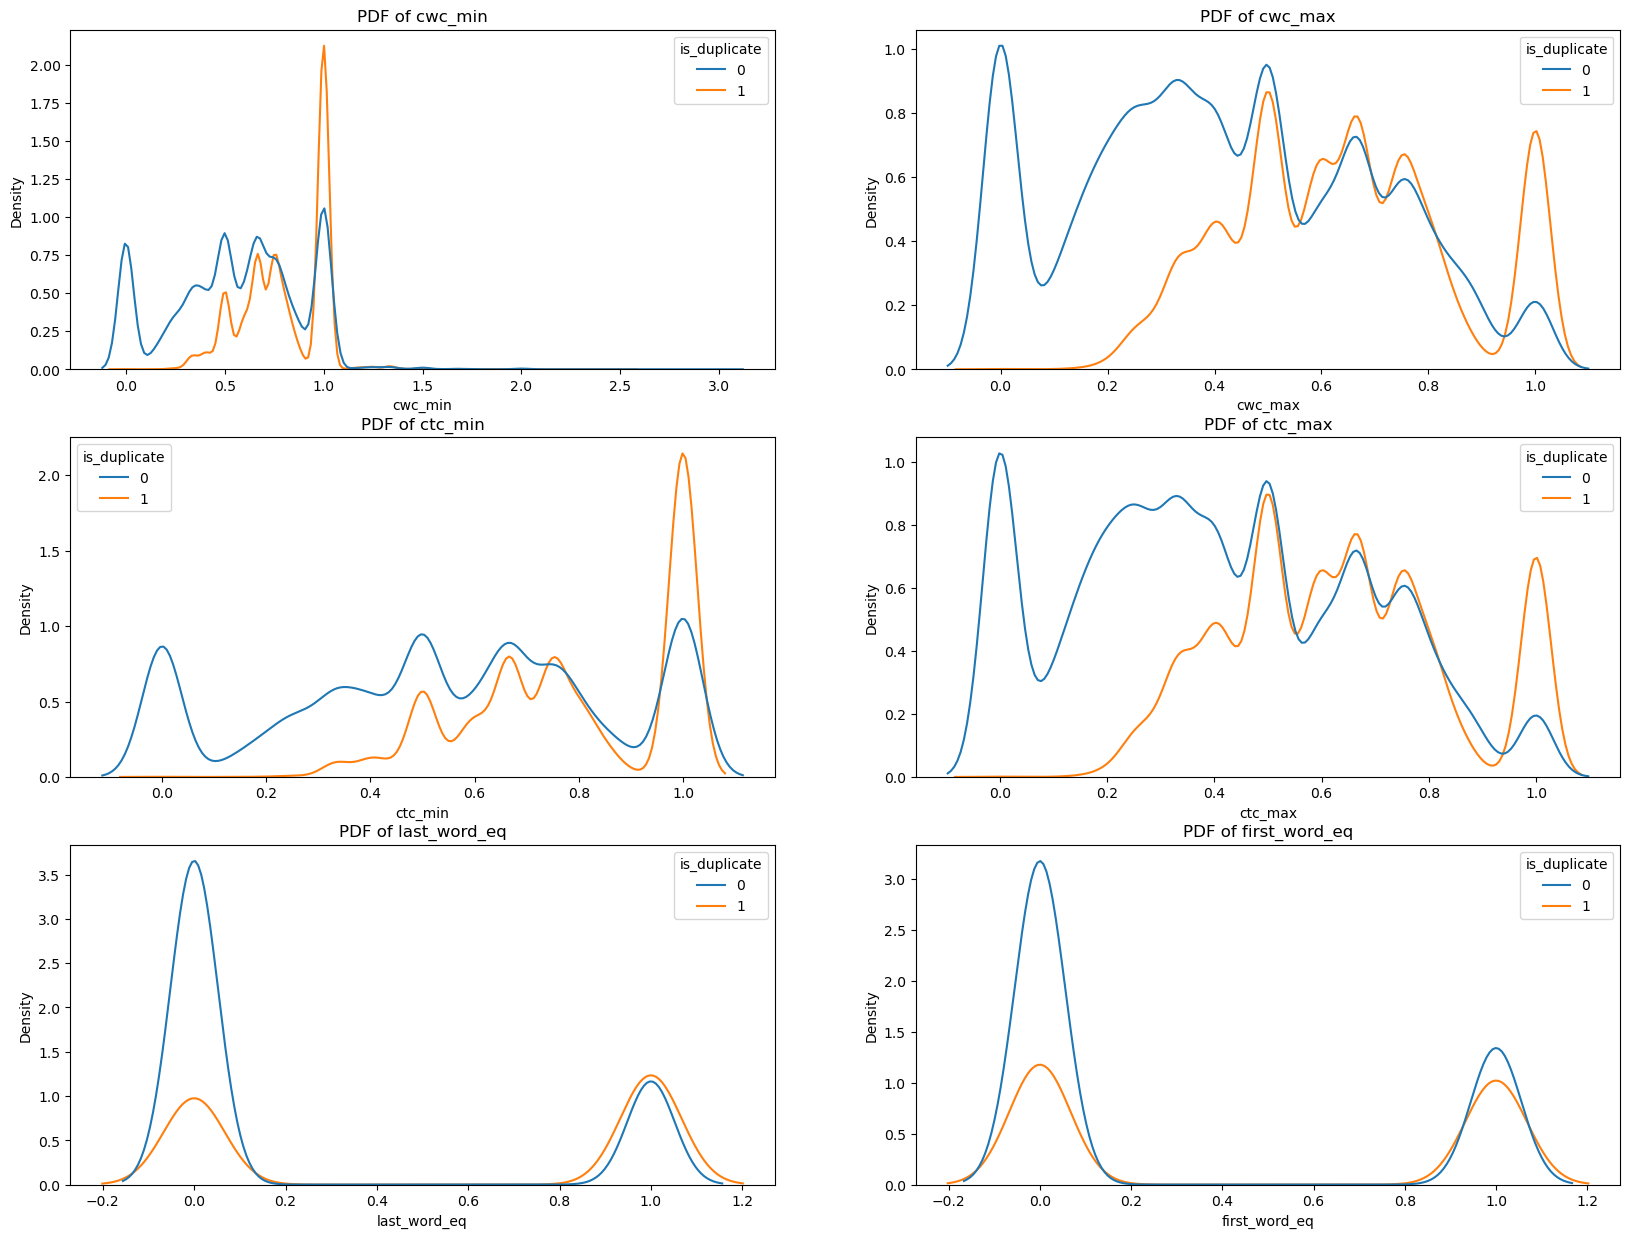

In [10]:
#pdf for token based features
fig,ax=plt.subplots(3,2,figsize=(20,15))
ax[0,0].title.set_text('PDF of cwc_min')
ax[0,1].title.set_text('PDF of cwc_max')
ax[1,0].title.set_text('PDF of ctc_min')
ax[1,1].title.set_text('PDF of ctc_max')
ax[2,0].title.set_text('PDF of last_word_eq')
ax[2,1].title.set_text('PDF of first_word_eq')
sns.kdeplot(data,x='cwc_min',hue='is_duplicate',ax=ax[0,0])
sns.kdeplot(data,x='cwc_max',hue='is_duplicate',ax=ax[0,1])
sns.kdeplot(data,x='ctc_min',hue='is_duplicate',ax=ax[1,0])
sns.kdeplot(data,x='ctc_max',hue='is_duplicate',ax=ax[1,1])
sns.kdeplot(data,x='last_word_eq',hue='is_duplicate',ax=ax[2,0])
sns.kdeplot(data,x='first_word_eq',hue='is_duplicate',ax=ax[2,1])
plt.show()


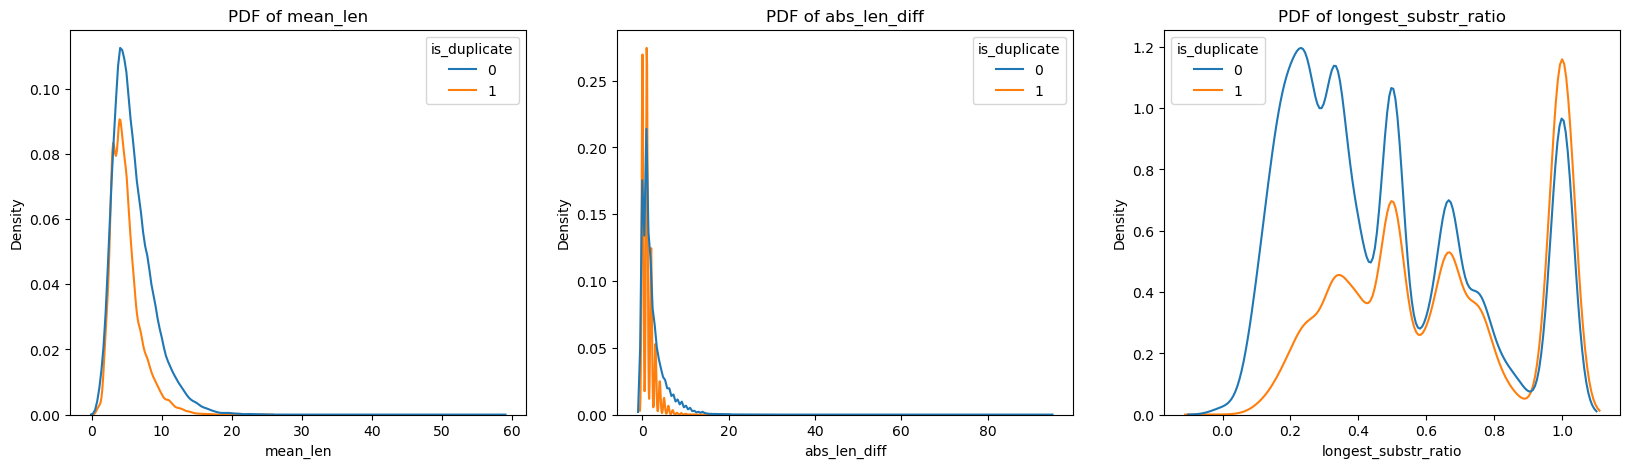

In [11]:
#pdf for token based features
fig,ax=plt.subplots(1,3,figsize=(20,5))
ax[0].title.set_text('PDF of mean_len')
ax[1].title.set_text('PDF of abs_len_diff')
ax[2].title.set_text('PDF of longest_substr_ratio')

sns.kdeplot(data,x='mean_len',hue='is_duplicate',ax=ax[0])
sns.kdeplot(data,x='abs_len_diff',hue='is_duplicate',ax=ax[1])
sns.kdeplot(data,x='longest_substr_ratio',hue='is_duplicate',ax=ax[2])

plt.show()


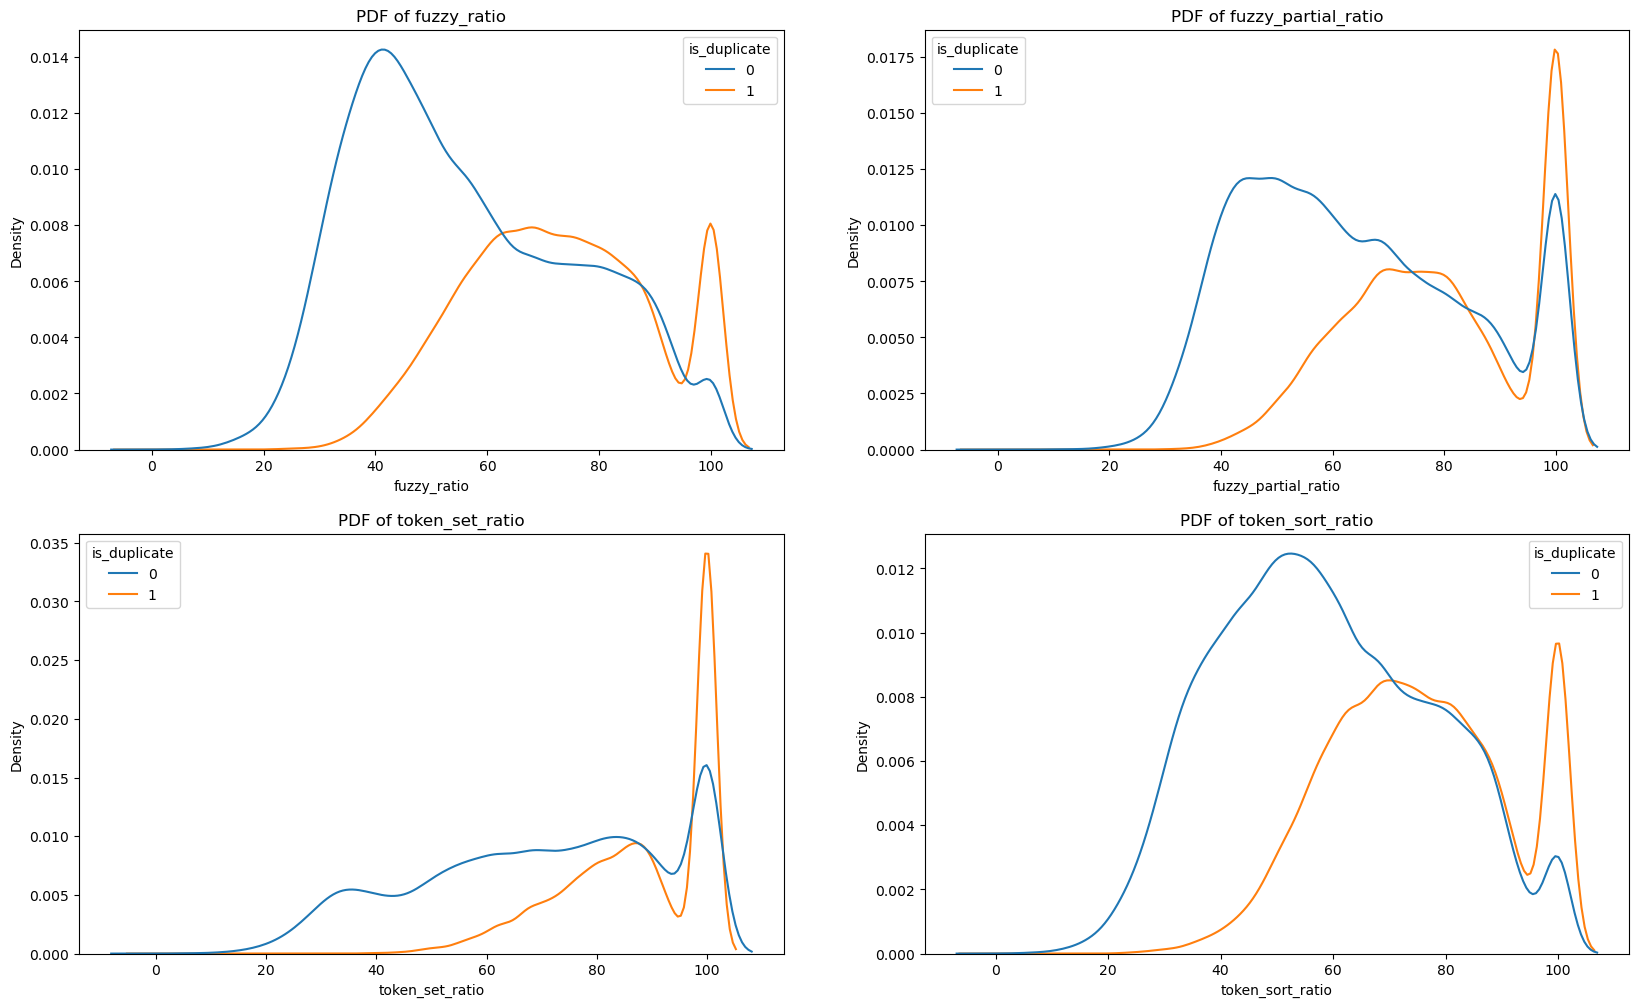

In [12]:
#pdf of fuzzy based features
fig,ax=plt.subplots(2,2,figsize=(20,12))
ax[0,0].title.set_text('PDF of fuzzy_ratio')
ax[0,1].title.set_text('PDF of fuzzy_partial_ratio')
ax[1,0].title.set_text('PDF of token_set_ratio')
ax[1,1].title.set_text('PDF of token_sort_ratio')

sns.kdeplot(data,x='fuzzy_ratio',hue='is_duplicate',ax=ax[0,0])
sns.kdeplot(data,x='fuzzy_partial_ratio',hue='is_duplicate',ax=ax[0,1])
sns.kdeplot(data,x='token_set_ratio',hue='is_duplicate',ax=ax[1,0])
sns.kdeplot(data,x='token_sort_ratio',hue='is_duplicate',ax=ax[1,1])

plt.show()

### Observation:

* We can clearly see a good sense of separation between <b>is_duplicate classes</b> in all the PDFs of advance features 

#### Now let's do some modelling and try of find its perfomance now

In [13]:
cv=CountVectorizer(max_features=30)
ques_list=list(data['question1'])+list(data['question2'])
q1,q2=np.vsplit(cv.fit_transform(ques_list).toarray(),2)
ques_1=pd.DataFrame(q1,index=data.index)
ques_2=pd.DataFrame(q2,index=data.index)
tot_list=pd.concat([ques_1,ques_2],axis=1)
tot_list.shape



(59984, 60)

In [14]:
temp_data=data[['len_ques1','len_ques2','q1_wordcount','q2_wordcount','word_share','cwc_min','cwc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','mean_len','abs_len_diff','longest_substr_ratio','fuzzy_ratio','fuzzy_partial_ratio','token_set_ratio','token_sort_ratio','is_duplicate']]
data_df=pd.concat([temp_data,tot_list],axis=1)
data_df.shape

(59984, 79)

In [15]:
X,Y=data_df.drop('is_duplicate',axis=1),data_df['is_duplicate']

In [16]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.1,stratify=Y,random_state=42)


In [17]:
rf_model=RandomForestClassifier(n_estimators=50)
rf_model.fit(X_train,Y_train)

c:\Users\asus\anaconda3\envs\Quora\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


RandomForestClassifier(n_estimators=50)

In [18]:
import warnings
warnings.filterwarnings('ignore')
#Calculate train accuracy
print("Train accuracy: ",accuracy_score(Y_train,rf_model.predict(X_train)))
#Calculate test accuracy
print("Test accuracy: ",accuracy_score(Y_test,rf_model.predict(X_test)))

Train accuracy:  0.9805316291562471
Test accuracy:  0.7466244374062344


In [19]:
grid={
    'max_features':[20,30],
    'max_depth':[15,20]
}

In [20]:
best_rf=GridSearchCV(rf_model,param_grid=grid,cv=2)
best_rf.fit(X_train,Y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_estimators=50),
             param_grid={'max_depth': [15, 20], 'max_features': [20, 30]})

In [21]:
import warnings
warnings.filterwarnings('ignore')
#Calculate train accuracy
print("Train accuracy: ",accuracy_score(Y_train,best_rf.predict(X_train)))
#Calculate test accuracy
print("Test accuracy: ",accuracy_score(Y_test,best_rf.predict(X_test)))

Train accuracy:  0.8337501157728999
Test accuracy:  0.7441240206701116


In [22]:
best_rf.best_estimator_

RandomForestClassifier(max_depth=15, max_features=20, n_estimators=50)

In [23]:
best_rf.predict_proba(X_train)

array([[0.58089968, 0.41910032],
       [0.99779476, 0.00220524],
       [0.60053152, 0.39946848],
       ...,
       [0.48928963, 0.51071037],
       [0.31551729, 0.68448271],
       [0.66867264, 0.33132736]])

In [24]:
train_score=log_loss(Y_train,best_rf.predict_proba(X_train))
test_score=log_loss(Y_test,best_rf.predict_proba(X_test))
print("Train loss=",train_score*100)
print("Test loss=",test_score*100)

Train loss= 37.89806273114009
Test loss= 48.09511425164711


#### Visualizing the high dimensional data distribution using TSNE to understand the separability

In [25]:
scaler=StandardScaler()
data_scale=scaler.fit_transform(data_df)

In [26]:
tsne=TSNE(n_components=2,perplexity=20)
tsne_res=tsne.fit_transform(data_scale)
tsne_res.shape



(59984, 2)

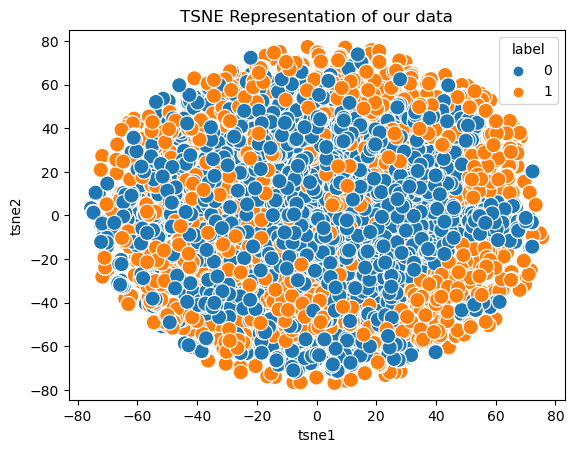

In [27]:
tsne_df=pd.DataFrame({'tsne1':tsne_res[:,0],'tsne2':tsne_res[:,1],'label':Y})
fig,ax=plt.subplots(1)
sns.scatterplot(x='tsne1',y='tsne2',hue='label',data=tsne_df,ax=ax,s=120)
plt.title("TSNE Representation of our data")
plt.show()

In [28]:
sent=[word.split() for word in ques_list]
w2vmodel=Word2Vec(sent,window=3,vector_size=30,sg=1)
#w2vmodel.build_vocab(ques_list)
#w2vmodel.train(ques_list,total_examples=w2vmodel.corpus_count,epochs=w2vmodel.epochs)


In [29]:
tfidf=TfidfVectorizer()
tfidf.fit_transform(ques_list)
word2tfidf=dict(zip(tfidf.get_feature_names(),tfidf.idf_))


In [30]:
nlp=spacy.load("en_core_web_sm")
x=nlp("step step guid invest share market india")
len(x.vector)

96

In [ ]:
import tqdm
vec1=[]
ques_list2=list(data['question1'])+list(data['question2'])
for que in list(ques_list2):
    doc=nlp(que)
    
    mean_vec=np.zeros([len(doc),len(doc[0].vector)])
    for word in doc:
        
        vec=word.vector
        try:
            idf=word2tfidf[str(word)]
        except:
            idf=0
        mean_vec+=(vec*idf)
        
    mean_vec=mean_vec.mean(axis=0)
    vec1.append(mean_vec)



In [32]:
def keep_token(t):
    return (t.is_alpha and not(t.is_space or t.is_punct or t.is_stop or t.like_num))
def lemmatized(doc):
    return [ t.lemma_ for t in doc if keep_token(t)]
    


In [33]:
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
doc=[lemmatized(nlp(que)) for que in ques_list2]
docs_dict=Dictionary(doc)
docs_dict.compactify()

In [34]:
from gensim.matutils import sparse2full
docs_corpus=[docs_dict.doc2bow(doc) for doc in doc]
model_tfidf=TfidfModel(docs_corpus,id2word=docs_dict)
docs_tfidf=model_tfidf[docs_corpus]
docs_vec=np.vstack([sparse2full(c,len(docs_dict)) for c in docs_tfidf])
docs_vec.shape


(119968, 27612)

In [35]:
tfidf_emb_vecs=np.vstack([nlp(docs_dict[i]).vector for i in range(len(docs_dict))])
tfidf_emb_vecs.shape

(27612, 96)

In [36]:
docs_emb=np.dot(docs_vec,tfidf_emb_vecs)
q1,q2=np.vsplit(docs_emb,2)
qu1=pd.DataFrame(q1,columns=range(0,96),index=data.index)
qu2=pd.DataFrame(q2,columns=range(96,192),index=data.index)
tot_df=pd.concat([qu1,qu2],axis=1)
tot_df.shape

(59984, 192)

In [37]:
df2=pd.concat([temp_data,tot_df],axis=1)
df2.shape

(59984, 211)

In [38]:
X,Y=df2.drop('is_duplicate',axis=1),df2['is_duplicate']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,stratify=Y,random_state=42)
rf_model=RandomForestClassifier(n_estimators=50)


In [ ]:
grid={
    'max_features':[20,30],
    'max_depth':[15,20]
}
best_rf=GridSearchCV(rf_model,param_grid=grid,cv=2)
best_rf.fit(X_train,Y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_estimators=50),
             param_grid={'max_depth': [15, 20], 'max_features': [20, 30]})

In [ ]:
import warnings
warnings.filterwarnings('ignore')
#Calculate train accuracy
print("Train accuracy: ",accuracy_score(Y_train,best_rf.predict(X_train)))
#Calculate test accuracy
print("Test accuracy: ",accuracy_score(Y_test,best_rf.predict(X_test)))

Train accuracy:  0.9690149566542822
Test accuracy:  0.7518337408312958


In [ ]:
train_score=log_loss(Y_train,best_rf.predict_proba(X_train))
test_score=log_loss(Y_test,best_rf.predict_proba(X_test))
print("Train loss=",train_score*100)
print("Test loss=",test_score*100)

Train loss= 26.941832696289776
Test loss= 47.55444145349804


In [ ]:
svc_mod=SVC(probability=True)
svc_mod.fit(X_train,Y_train)

SVC(probability=True)

In [ ]:
train_score=log_loss(Y_train,svc_mod.predict_proba(X_train))
test_score=log_loss(Y_test,svc_mod.predict_proba(X_test))
print("Train loss=",train_score*100)
print("Test loss=",test_score*100)

Train loss= 54.30652949842448
Test loss= 54.027092264346656


In [ ]:
warnings.filterwarnings('ignore')
#Calculate train accuracy
print("Train accuracy: ",accuracy_score(Y_train,svc_mod.predict(X_train)))
#Calculate test accuracy
print("Test accuracy: ",accuracy_score(Y_test,svc_mod.predict(X_test)))

Train accuracy:  0.7006525674002095
Test accuracy:  0.7051011335852412


In [ ]:
import xgboost
params={}
params['objective']='binary:logistic'
params['eval_metric']='logloss'
params['eta']=0.02
params['max_depth']=4
d_train=xgboost.DMatrix(X_train,label=Y_train)
d_test=xgboost.DMatrix(X_test,label=Y_test)
watchlist=[(d_train,'train'),(d_test,'valid')]
bst=xgboost.train(params,d_train,400,watchlist,early_stopping_rounds=50,verbose_eval=50)
#xgdmat=xgboost.DMatrix(X_train,Y_train)
Y_pred_train=bst.predict(d_train)
Y_pred_test=bst.predict(d_test)
print("The train loss:",log_loss(Y_train,Y_pred_train,eps=1e-15))
print("The test loss:",log_loss(Y_test,Y_pred_test,eps=1e-15))


[0]	train-logloss:0.68741	valid-logloss:0.68750
[50]	train-logloss:0.54996	valid-logloss:0.55216
[100]	train-logloss:0.51292	valid-logloss:0.51652
[150]	train-logloss:0.49801	valid-logloss:0.50336
[200]	train-logloss:0.48935	valid-logloss:0.49705
[250]	train-logloss:0.48256	valid-logloss:0.49283
[300]	train-logloss:0.47528	valid-logloss:0.48871
[350]	train-logloss:0.46899	valid-logloss:0.48550
[399]	train-logloss:0.46364	valid-logloss:0.48282
The train loss: 0.46364123970172116
The test loss: 0.48282186630338825


In [39]:
import xgboost as xgb 
xgb_cl=xgb.XGBClassifier(n_estimators=20,max_depth=5,random_state=42)
xgb_cl.fit(X_train,Y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [40]:
print("The train loss:",log_loss(Y_train,xgb_cl.predict_proba(X_train),eps=1e-15))
print("The test loss:",log_loss(Y_test,xgb_cl.predict_proba(X_test),eps=1e-15))


The train loss: 0.45289647957888374
The test loss: 0.48154105134311315


### Observations:
* So let's see the perfomances of different models in tabular format below:

|Models|Train_score|Test_score|Remark|
|------|-----------|----------|------|
|LogisticRegression  on raw data|0.44|0.56|Overfitting|
|LogisticRegression on basic preprocessed date|0.63|0.63|NA|
|RandomForestClassifier|0.54|0.79|Overfitting|
|RandomForestClassifier on weighted TFIDF word2vec|0.27|0.47|Overfitting|
|Support Vector Classifier on word2vec|0.54|0.54|Balanced Fit|
|XGBoost Classifier on word2vec|0.45|0.48|Balanced Fit|

* As the XGBoost model gives us the best performance, we'll be using it for prediction but before that we need to save this model:

In [47]:
joblib.dump(xgb_cl,r'C:\Users\asus\Documents\Projects\Question_Similarity_Pairs\model\xgb_model.pkl')

['C:\\Users\\asus\\Documents\\Projects\\Question_Similarity_Pairs\\model\\xgb_model.pkl']